https://pyomo.readthedocs.io/en/stable/ <br>
https://pyomo.readthedocs.io/en/stable/working_models.html

In [25]:
import pyomo.environ as pyo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Eingabedaten

In [2]:
input_data = pd.read_excel("Inputdata.xlsx", index_col="Land")

input_data

input_data.to_dict()

input_data["H2 Herstellungspreis"].to_dict()

## Solver

In [3]:
solver = pyo.SolverFactory('gurobi') 

## Model

In [4]:
model = pyo.ConcreteModel()

## Länder als itterable

input_data.index

In [5]:
model.country = input_data.index

## Parameter

In [6]:
# Parameter in Model importieren
model.h2_price =  pyo.Param(model.country, initialize=input_data["H2 Herstellungspreis"].to_dict())
model.h2_pipeline =  pyo.Param(model.country, initialize=input_data["H2 Pipeline Preis"].to_dict())
model.h2_ship =  pyo.Param(model.country, initialize=input_data["H2 Schiff Preis"].to_dict())
model.h2_limit = pyo.Param(model.country, initialize=input_data["H2 Export Limit"].to_dict())

model.nh3_price =  pyo.Param(model.country, initialize=input_data["NH3 Herstellungspreis"].to_dict())
model.nh3_pipeline =  pyo.Param(model.country, initialize=input_data["NH3 Pipeline Preis"].to_dict())
model.nh3_ship =  pyo.Param(model.country, initialize=input_data["NH3 Schiff Preis"].to_dict())
model.nh3_limit = pyo.Param(model.country, initialize=input_data["NH3 Export Limit"].to_dict())

model.ch3oh_price =  pyo.Param(model.country, initialize=input_data["CH3OH Herstellungspreis"].to_dict())
model.ch3oh_pipeline =  pyo.Param(model.country, initialize=input_data["CH3OH Pipeline Preis"].to_dict())
model.ch3oh_ship =  pyo.Param(model.country, initialize=input_data["CH3OH Schiff Preis"].to_dict())
model.ch3oh_limit = pyo.Param(model.country, initialize=input_data["CH3OH Export Limit"].to_dict())

model.h2_price.pprint()

## Variablen

In [7]:
# Variablen definieren
model.h2_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.h2_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

model.nh3_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.nh3_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

model.ch3oh_amount_ship = pyo.Var(model.country, domain = pyo.NonNegativeReals)
model.ch3oh_amount_pipeline = pyo.Var(model.country, domain = pyo.NonNegativeReals)

## Zielfunktion

In [8]:
# Zielfunktion
obj_expr = sum(model.h2_pipeline[i]*model.h2_amount_pipeline[i] + model.h2_ship[i]*model.h2_amount_ship[i] + model.h2_price[i]*(model.h2_amount_pipeline[i] + model.h2_amount_ship[i]) +
               model.nh3_pipeline[i]*model.nh3_amount_pipeline[i] + model.nh3_ship[i]*model.nh3_amount_ship[i] + model.nh3_price[i]*(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]) +
               model.ch3oh_pipeline[i]*model.ch3oh_amount_pipeline[i] + model.ch3oh_ship[i]*model.ch3oh_amount_ship[i] + model.ch3oh_price[i]*(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]) for i in model.country)
model.obj = pyo.Objective(sense=pyo.minimize, expr=obj_expr)

# müssen noch gemacht werden

## Nebenbedingungen

In [9]:
# Bedarfsdeckung
model.demand_constraints = pyo.ConstraintList()

con_demand_h2_lhs = sum(model.h2_amount_pipeline[i] + model.h2_amount_ship[i] for i in model.country)
con_demand_h2_rhs = 1000000
model.demand_constraints.add(con_demand_h2_lhs >= con_demand_h2_rhs)

con_demand_nh3_lhs = sum(model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i] for i in model.country)
con_demand_nh3_rhs = 1000000
model.demand_constraints.add(con_demand_nh3_lhs >= con_demand_nh3_rhs)

con_demand_ch3oh_lhs = sum(model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i] for i in model.country)
con_demand_ch3oh_rhs = 1000000
model.demand_constraints.add(con_demand_ch3oh_lhs >= con_demand_ch3oh_rhs)

# Exportlimits
model.export_constraints = pyo.ConstraintList()

for i in model.country:
    con_export_h2_lhs = model.h2_amount_pipeline[i] + model.h2_amount_ship[i]
    con_export_h2_rhs = model.h2_limit[i]
    model.export_constraints.add(con_export_h2_lhs <= con_export_h2_rhs)
    
    con_export_nh3_lhs = model.nh3_amount_pipeline[i] + model.nh3_amount_ship[i]
    con_export_nh3_rhs = model.nh3_limit[i]
    model.export_constraints.add(con_export_nh3_lhs <= con_export_nh3_rhs)
    
    con_export_ch3oh_lhs = model.ch3oh_amount_pipeline[i] + model.ch3oh_amount_ship[i]
    con_export_ch3oh_rhs = model.ch3oh_limit[i]
    model.export_constraints.add(con_export_ch3oh_lhs <= con_export_h2_rhs)


model.pprint()

In [10]:
# Create a model instance and optimize
instance = model.create_instance()
results = solver.solve(instance)
#instance.display()

Model unknown

  Variables:
    h2_amount_ship : Size=113, Index=h2_amount_ship_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
        nan :     0 :   0.0 :  None : False : False : NonNegativeReals
         AE :     0 :   0.0 :  None : False : False : NonNegativeReals
         AO :     0 :   0.0 :  None : False : False : NonNegativeReals
         AR :     0 :   0.0 :  None : False : False : NonNegativeReals
         AT :     0 :   0.0 :  None : False : False : NonNegativeReals
         AU :     0 :   0.0 :  None : False : False : NonNegativeReals
         AZ :     0 :   0.0 :  None : False : False : NonNegativeReals
         BD :     0 :   0.0 :  None : False : False : NonNegativeReals
         BE :     0 :   0.0 :  None : False : False : NonNegativeReals
         BF :     0 :   0.0 :  None : False : False : NonNegativeReals
         BG :     0 :   0.0 :  None : False : False : NonNegativeReals
         BH :     0 :   0.0 :  None : False : False : NonNegativeReals
 

In [11]:
instance.h2_amount_pipeline["AT"].value

4414.865380464008

In [13]:
# save model results to dicts
opt_h2_amount_pipeline = {x:instance.h2_amount_pipeline[x].value for x in instance.country}
opt_h2_amount_ship = {x:instance.h2_amount_ship[x].value for x in instance.country}

opt_nh3_amount_pipeline = {x:instance.nh3_amount_pipeline[x].value for x in instance.country}
opt_nh3_amount_ship = {x:instance.nh3_amount_ship[x].value for x in instance.country}

opt_ch3oh_amount_pipeline = {x:instance.ch3oh_amount_pipeline[x].value for x in instance.country}
opt_ch3oh_amount_ship = {x:instance.ch3oh_amount_ship[x].value for x in instance.country}

In [21]:
opt_nh3_amount_ship.values()

dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5270.444406258586, 0.0, 0.0, 0.0, 0.0, 11988.374170125537, 0.0, 100258.50653946456, 0.0, 0.0, 0.0, 0.0, 0.0, 305605.6055591096, 0.0, 118173.74695492536, 0.0, 0.0, 231051.19436475218, 0.0, 0.0, 0.0, 8367.388522881405, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27400.623422332217, 7778.578054138736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 128155.74408932282, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22973.740426713597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

fig, ax = plt.subplots(2,3, sharey=True, figsize = (16,9))

ax[0,0].set_title("H2 Schiff")
sns.barplot(x=list(opt_h2_amount_ship.keys()), y = list(opt_h2_amount_ship.values()), ax = ax[0,0])
ax[1,0].set_title("H2 Pipeline")
sns.barplot(x=list(opt_h2_amount_pipeline.keys()), y = list(opt_h2_amount_pipeline.values()), ax = ax[1, 0])

ax[0,1].set_title("NH3 Schiff")
sns.barplot(x=list(opt_nh3_amount_ship.keys()), y = list(opt_nh3_amount_ship.values()), ax = ax[0,1])
ax[1,1].set_title("NH3 Pipeline")
sns.barplot(x=list(opt_nh3_amount_pipeline.keys()), y = list(opt_nh3_amount_pipeline.values()), ax = ax[1, 1])

ax[0,2].set_title("CH3OH Schiff")
sns.barplot(x=list(opt_ch3oh_amount_ship.keys()), y = list(opt_ch3oh_amount_ship.values()), ax = ax[0,2])
ax[1,2].set_title("CH3OH Pipeline")
sns.barplot(x=list(opt_ch3oh_amount_pipeline.keys()), y = list(opt_ch3oh_amount_pipeline.values()), ax = ax[1, 2])


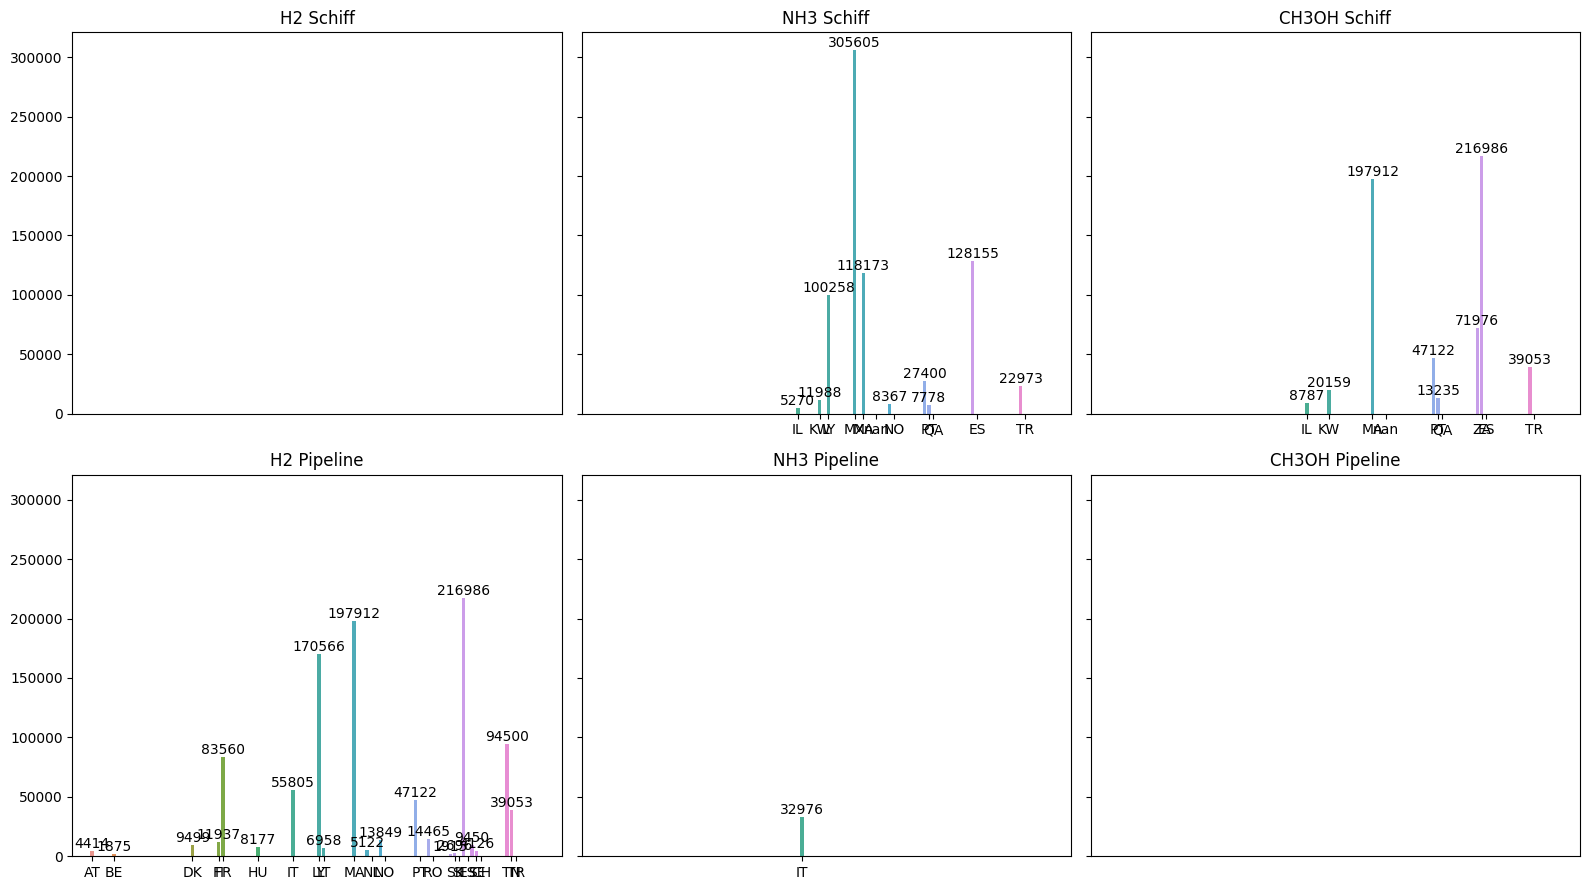

In [43]:
fig, ax = plt.subplots(2, 3, sharey=True, figsize=(16, 9))

def add_conditional_ticklabels(ax, x, y):
    valid_x = [x_val for x_val, y_val in zip(x, y) if y_val > 0]
    valid_idx = [i for i, y_val in enumerate(y) if y_val > 0]
    
    ax.set_xticks(valid_idx)
    ax.set_xticklabels(valid_x)
    
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                '%d' % int(height),
                ha='center',
                va='bottom'
            )

# H2
ax[0, 0].set_title("H2 Schiff")
sns.barplot(x=list(opt_h2_amount_ship.keys()), y=list(opt_h2_amount_ship.values()), ax=ax[0, 0])
ax[1, 0].set_title("H2 Pipeline")
sns.barplot(x=list(opt_h2_amount_pipeline.keys()), y=list(opt_h2_amount_pipeline.values()), ax=ax[1, 0])
add_conditional_ticklabels(ax[0, 0], list(opt_h2_amount_ship.keys()), list(opt_h2_amount_ship.values()))
add_conditional_ticklabels(ax[1, 0], list(opt_h2_amount_pipeline.keys()), list(opt_h2_amount_pipeline.values()))

# NH3
ax[0, 1].set_title("NH3 Schiff")
sns.barplot(x=list(opt_nh3_amount_ship.keys()), y=list(opt_nh3_amount_ship.values()), ax=ax[0, 1])
ax[1, 1].set_title("NH3 Pipeline")
sns.barplot(x=list(opt_nh3_amount_pipeline.keys()), y=list(opt_nh3_amount_pipeline.values()), ax=ax[1, 1])
add_conditional_ticklabels(ax[0, 1], list(opt_nh3_amount_ship.keys()), list(opt_nh3_amount_ship.values()))
add_conditional_ticklabels(ax[1, 1], list(opt_nh3_amount_pipeline.keys()), list(opt_nh3_amount_pipeline.values()))

# CH3OH
ax[0, 2].set_title("CH3OH Schiff")
sns.barplot(x=list(opt_ch3oh_amount_ship.keys()), y=list(opt_ch3oh_amount_ship.values()), ax=ax[0, 2])
ax[1, 2].set_title("CH3OH Pipeline")
sns.barplot(x=list(opt_ch3oh_amount_pipeline.keys()), y=list(opt_ch3oh_amount_pipeline.values()), ax=ax[1, 2])
add_conditional_ticklabels(ax[0, 2], list(opt_ch3oh_amount_ship.keys()), list(opt_ch3oh_amount_ship.values()))
add_conditional_ticklabels(ax[1, 2], list(opt_ch3oh_amount_pipeline.keys()), list(opt_ch3oh_amount_pipeline.values()))

plt.tight_layout()
plt.show()
